# Predicting cover crop biomass and N content using ML algorithms

This notebook features a sequential overview of steps involved in data preparation as well as selection, optimization, and validation of the best candidate models to predict late-season biomass and N-content of a winter-seeded rye cover crop; typical of organic corn production systems in the Northeast US. 

The notebook is meant to be run on a single call. It was written and set up on the Anaconda ecosystem (v 4.3.27; python v 3.6.6), and as such, it makes wide use of common methods and functions available in scipy (v 1.1.0), numpy (v 1.15.1), and sklearn (v 0.21.2). Recent updates to any of these packages should have no impact on it. Also, a supplementary ad-hoc set of functions for data aggregation, and model training, testing, and optimization (Rye_ML_functions), common to this project is packed as a separate notebook, and is called as a typical module via import statements when needed.

In [2]:
### Import libraries:
import warnings
import time
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import quantile_transform
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
import pickle                                                                      # to save trained models to disk
import matplotlib.pyplot as plt
import seaborn as sns

from ipynb.fs.defs import Rye_ML_functions as rmf                                  # Module with functions for this study

In [15]:
begin_time= time.perf_counter()
print("Simulation starts at : {} segs.".format(begin_time))

Simulation starts at : 433.4746462 segs.


## Data reading and preparation

20 early-season features were collected or created based on soil base content, early season allometric, and ground-remote sensed features available from a N rate field experiment at two US North-East locations (Beltsville, MD 2010/2011-2012/2012, and Pennsylvania, PA 2011/2012). Early season records on ground-based reflectance (Visible, Near-infrared) were combined, and used for computation of a common greenness indicator (NDVI). Also, shoot-N, shoot-C contents, tiller populations, and field sampled biomass previsouly recovered at growth stages 20 (tillering, or branching) and 30 (jointing, or pre-reproductive) were stored and merged into a full feature dataset. In addition, three additional features hypothesized to correlate with growth quantity and quality (i.e. dry-weight and residue composition) were created or "engineered":
- Tiller efficiency: Ratio between number of effective rye shoots per seed sown
- Rye nitrogen use: Ratio between shoot N content to N supply (i.e. base soil Nitrate plus N fertilizer rate)
- CN ratio: Ratio between carbon and nitrogen shoot contents

The features to predict were biomass and shoot-N_content at GS60 (Kg.ha-1). Reaching a cereal stage this late might be unusual under systems relying on chemical dissecation (herbicides), but is common timing for rolled cereal cover crops in organic corn production.

In [3]:
data_25= pd.read_csv('data_25.csv')
data_30= pd.read_csv('data_30.csv')
full=pd.merge(data_25, data_30, on=['state','location','year','plot','n_rate_fall','n_rate_spring'])

There is seemingly significant variation in spring biomass between locations and years. The response variable (biomass_60) is fairly normally distributed while the early season features require some level of  preparation. Conventionally, this is achieved through logarithmic or square-root transformations. Here, to correct for lack of normality among some independent features we use a feature-normalization method robust to outliers (evidenced in some years-site combinations), based on gaussian quantile-regression (*`The module "Rye_ML_functions includes a quite simple routine for this. However the code is not well documented at present`*).

In [4]:
#Note the feature to predict is the same in both datasets
aggr_loc_year= full.groupby(['state','location','year'])['biomass_60_y'].mean()
print("Mean rye biomass in 2 Mid-Atlantic locations, 2010-2012")
print(15 * "---")
print(aggr_loc_year)
print(15 * "---")

Mean rye biomass in 2 Mid-Atlantic locations, 2010-2012
---------------------------------------------
state  location    year
MD     Beltsville  2011     6076.028033
                   2012    13699.857150
PA     Larson      2012     7882.253067
Name: biomass_60_y, dtype: float64
---------------------------------------------


In [5]:
# Features to train and assess models at GS25 and GS30
vars_25= [col for col in data_25.columns if "25" in col]
vars_30= [col for col in data_30.columns if "30" in col]

# Transform data
X_25= rmf.X_data_transf(data_25, vars_25)
X_30= rmf.X_data_transf(data_30,vars_30)
X_full= rmf.X_data_transf(full,vars_25+vars_30)

### Correlation heatmap between rye inputs at GS25, GS30 (inputs) and biomass at GS60 (feature to predict)

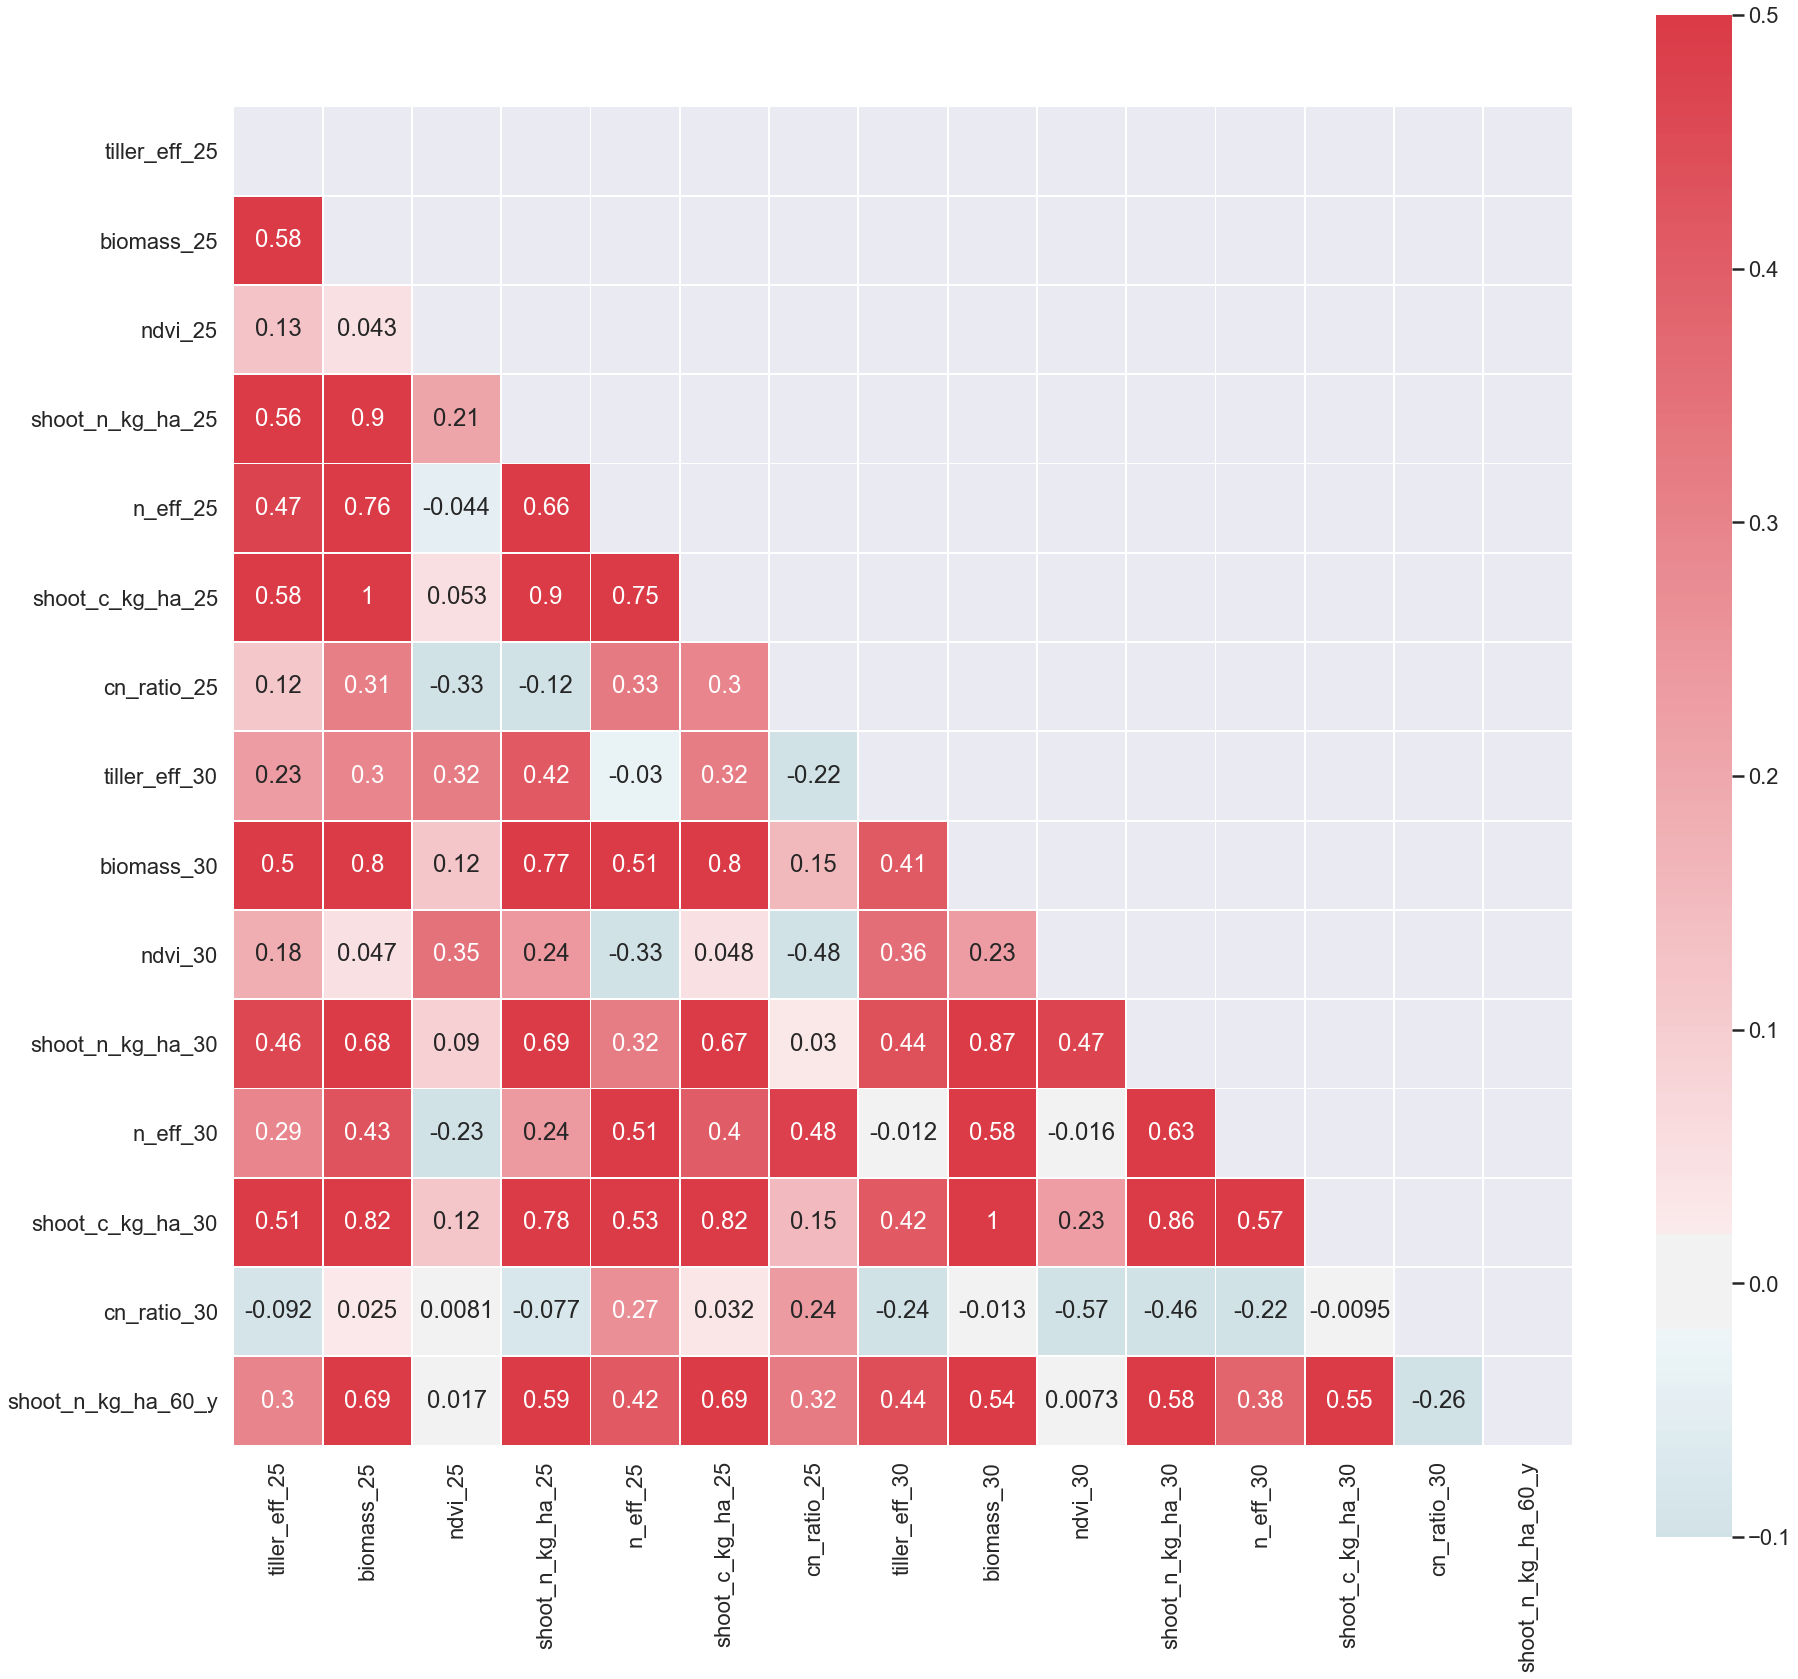

In [19]:
## Correlation heat-map between inputs and outputs

features= vars_25 + vars_30
output= ["shoot_n_kg_ha_60_y"]

# Corr matrix:
corr_rye= full.loc[:,features+output].corr()

# Mask the upper triangle:
mask= np.zeros_like(corr_rye, dtype= np.bool)
mask[np.triu_indices_from(mask)]= True

# Set up the matplotlib figure
f,ax= plt.subplots(figsize=(30,28))

# Generate a colormap:
cmap= sns.diverging_palette(220,10,as_cmap=True)

# Draw the heatmap with the mask

sns.heatmap(corr_rye, mask=mask, cmap=cmap, vmin=-0.1,vmax=0.50, center=0, #.3
               square=True,linewidths=0.85,annot=True)
sns.set(font_scale=1.8) 
sns.set_context("poster")
f.savefig("corr_rye_Ncontent.png")
plt.show()

In [6]:
# Data for modeling:
X_full
y_bm=full["biomass_60_y"].values
y_n= full["shoot_n_kg_ha_60_y"].values

## Modeling

### Model selection

Having a simple multiple regression as the default check model is more representative than judging model performance relative to a simple raw mean estimator $Yield= \frac{\sum_{n=i}^{yield_i}}{n}$. To overcome the limitations of a relatively small sample size and high correlation among predictors, we chose several candidate models, of which the better during the training phase were: Least Additive Selection Operator(LASSO) and an ensamble-based regressor (Random Forest). 

LASSO is a variant of linear regression in which additional terms (or penalties) are imposed on some parameters so that some are getting "shrunk" to zero, and in consequence, only the set of "best" parameters remain to reduce the difference between what is predicted and what is observed. Mathematically, this is equivalent to add a linear combination of weights relative to the own regression parameters, and find the optimal set that reduces the cost error function(i.e. RMSE). A Random Forest, on the other hand, is called an ensemble model because it combines predictions of multiple models in a "row" (*`is a bit more complex than that, but for sake of simplicity it is fine for now`*), averaging over multiple decision trees and reducing their own tendecy to overfit (decrease performance with new data) by resampling the data at every iteration.

Models were assessed on the basis of predictive capabilities (prediction errors: **`RMSE, MAE, R-square`**) and their abilities to capture true signals outside the initial predictions during the training-phase (**`Model Bias, and Model Variance`**).

In [6]:
# ----------------------------------- Initial model training  ----------------------------------------------
## ---------------------------- Pipeline for easier model fitting: -----------------------------------------

# Instantiate candidate models (un-optimized, run at default parameter values):

tr_models= {"lm":LinearRegression(),
            "ridge":Ridge(),
            "lasso": Lasso(),
            "rf": RandomForestRegressor(random_state=0)}

In [7]:
# Test performance of the four candidate models --- Rye biomass, kg.ha
dfs_test_bm=[
    rmf.model_train_test(
        output= y_bm,
        x_sample=X_full,
        model= tr_models[model],
        phase='test',
        test_size=0.7
    ) for model in list(tr_models.keys())
]


pd.concat(dfs_test_bm).set_index(pd.Series(list(tr_models.keys())))

,bias,var,rmse,mae,r2
lm,106.007520,1.547397e+07,3247.756026,2270.152927,0.183294
ridge,233.462260,1.246642e+07,2715.194071,2021.243200,0.429178
lasso,116.705393,1.528111e+07,3206.162517,2252.054264,0.204079
rf,244.932420,1.011768e+07,2306.302412,1810.444263,0.588157


In [8]:
# Test performance of the four candidate models --- Rye shoot-N content, kg.ha
dfs_test_n=[
    rmf.model_train_test(
        output= y_n,
        x_sample=X_full,
        model= tr_models[model],
        phase='test',
        test_size=0.7
    ) for model in list(tr_models.keys())
]


pd.concat(dfs_test_n).set_index(pd.Series(list(tr_models.keys())))

,bias,var,rmse,mae,r2
lm,-1.136119,3419.144664,46.680005,30.999432,0.079252
ridge,1.602399,2308.826720,35.887920,25.698280,0.455778
lasso,0.906989,2314.459188,34.683371,25.611571,0.491698
rf,-0.193739,1347.389282,34.093517,26.631546,0.508840


### Model optimization

In [24]:
## ---- Not Run ------------------------------------------------------ #####
## ----------------- Model Optimization via GridSearch --------------- #####
## I am using GridSearch. Hyper-parameters to select are different per model
## Features to predict are different as well. A 10-CV split is used.
## Thus, It is better to run the search one model at a time           #####
## -------------------------------------------------------------------#####

## ------ Optimize the best biomass model: Random Forest ------------ #####
warnings.filterwarnings(action="ignore")

t0= time.clock()
rf_pars= {"n_estimators": np.arange(100,5000,250),
          "min_samples_split": np.arange(2,10,1)}

rf_opt= GridSearchCV(estimator=tr_models["rf"], 
                     param_grid=rf_pars, 
                     cv=10,
                     return_train_score=False)
rf_opt.fit(X_full,y_bm)
tf= time.clock()
print("Optimization execution time: {}".format( (tf-t0)))

best_rf= rf_opt.best_estimator_

# Saving the best model to disk for faster testing later on
rf_filename= 'best_rf.sav'
pickle.dump(best_rf, open(rf_filename,'wb'))

## ------ Optimize the best shoot N model: Lasso ------------ #####
## --- not run -------------------------------------------
warnings.filterwarnings(action="ignore")

ls_pars= np.arange(0,1000,0.5)

t0= time.clock()
ls_opt= GridSearchCV(estimator= tr_models["lasso"],
             param_grid= {"alpha":ls_pars},
             cv=10,
             return_train_score= False)

ls_opt.fit(X_full, y_n)
tf= time.clock()
print("Optimization execution time: {}".format( (tf-t0)))
best_ls= ls_opt.best_estimator_

# Saving the best lasso model for faster testing later on:
lasso_filename= "best_lasso.sav"
pickle.dump(best_ls, open(lasso_filename,'wb'))

# For later tests:
# load_model= pickle.load(open(rf_filename, 'rb'))
# load_model.predict(.)

Optimization execution time: 5350.4198081
Optimization execution time: 18.64865710000049


In [7]:
# Instantiate optimized models
rf_opt_bm= pickle.load(open('best_rf.sav','rb'))
ls_opt_n= pickle.load(open('best_lasso.sav','rb'))

### Model Validation

In [26]:
# ---- Not Run  ----------------------------------------------------
# ---------- Leave-one-out cross-validation (biomass): ------------------------------

# ---results biomass-------------------------------------------------
rf_opt_bm_results= rmf.model_validation(y_sample= y_bm, x_sample=X_full, model= rf_opt_bm)
rf_opt_bm_results.apply(lambda x: np.mean(x), axis=0).to_frame()
print("RMSE, kg.ha: ", np.sqrt(4.157974e+06))

# ---------- Leave one out cross validation (N-shoot content) ----------------------------------------
ls_opt_n_results= rmf.model_validation(y_sample= y_n, x_sample=X_full,model= ls_opt_n)
ls_opt_n_results.apply(lambda x: np.mean(x), axis=0).to_frame()
print("RMSE, kg.ha: ",np.sqrt(1137.330916))
# end not run -----------------------------------------------------
# -------------------------------------------------------------------

Mean prediction estimate 9214.99426782118
Model R2: 0.697
RMSE, kg.ha:  2039.1110808389033
Mean prediction estimate 107.01579785345002
Model R2: 0.546
RMSE, kg.ha:  33.724337146932925


In [27]:
#print('Biomass-Random Forest (1100 estimators, 3 samples/split), LOOCV')
#rf_opt_bm_results.apply(lambda x: np.mean(x), axis=0).to_frame().T
print('Shoot Nitrogen-LASSO (alpha=3.0), LOOCV')
ls_opt_n_results.apply(lambda x: np.mean(x), axis=0).to_frame().T

Shoot Nitrogen-LASSO (alpha=3.0), LOOCV


,pred,bias,var,mse,mae
0,107.015798,0.194635,1149.380314,1137.330916,25.446732


### Model application: Evaluate rye predictions from two ML models at different N environments

The two optimized Models were fitted to a fresh set of 120 observations, all from a rye response trial to N fertilizer in North Carolina. Experimental conditions were similar to those of the training and testing dataset. Predictors for this dataset were available only for rye at stage 30. To increase our space for inference, mean and 95% bootstrap estimates were generated for a biomass and shoot-N prediction recorded at every N rate combination in the original layout.

In [37]:
# Site and treatment information:

NC_outputs=["biomass_60","shoot_n_kg_ha_60"]

NC_sites= ["Kinston","Salisbury"]

n_rate_fall= list(full.n_rate_fall.unique())
n_rate_spring= list(full.n_rate_spring.unique())

# Select testing dataset:

NC_test=[rmf.select_data(location=site,year=2012,n_rate_fall=fr,n_rate_spring=sr,data=data_30)
         for site in NC_sites
         for fr in n_rate_fall
         for sr in n_rate_spring
        ]
NC_df= pd.concat(NC_test)

In [27]:
# ------------------------ Biomass Predictions ----------------------------------- ########

# Obtain mean observations per treatment:

NC_means= NC_df.groupby(["state","location","year","n_rate_fall","n_rate_spring"], as_index=False)["biomass_60"].mean()

# Generate 95% bootstrap estimates per treatment:

NC_boots= [rmf.bootstraps_summary(
        data= rmf.select_data(
            location= site,
            year= 2012,
            n_rate_fall= fr,
            n_rate_spring= sr,
            data=data_30
        ),
        n_samples= 1500,
        sample_size= 3,
        output='biomass_60'
    )
    for site in NC_sites
    for fr in n_rate_fall
    for sr in n_rate_spring
]

NC_b= pd.concat(NC_boots)

# Obtain ML predictions using the optimized model
rf_bm_NC= rf_opt_bm.fit(X= np.array(NC_df.loc[:,vars_30]),
                        y= NC_df.biomass_60.values)
NC_preds= rf_bm_NC.predict(np.array(NC_df.loc[:,vars_30]))    # vector of predictions (~np.array[n,])

# Attach predictions to df
NC_df["pred_biomass"]= NC_preds

# Obtain vector of mean predictions for biomass, aggreagated @ every N-rate  :
NC_mean_preds= NC_df.groupby(
    by= ["state","location","year","n_rate_fall","n_rate_spring"],
    as_index=False
)['pred_biomass'].mean().pred_biomass.values

# Finally attach this vector to the table of bootstrap estimates
NC_b["pred_biomass"]= NC_mean_preds

# Attach other columns of interest
#Final Biomass dataset -----------------------------------------------------------------(NC-testing data)
NC_b["obs_mean"]= NC_means["biomass_60"].values
NC_b["total_N_rate"]= NC_means["n_rate_fall"].values + NC_means["n_rate_spring"].values
NC_b["upper_obs_mean"]= NC_means["biomass_60"].values + NC_b["error_bst"].values
NC_b["lower_obs_mean"]= NC_means["biomass_60"].values - NC_b["error_bst"].values

In [28]:
# ------------------------Shoot N content, predictions ----------------------------------- ########

# Obtain mean observations per treatment:

NC_means_n= NC_df.groupby(["state","location","year","n_rate_fall","n_rate_spring"], as_index=False)["shoot_n_kg_ha_60"].mean()

# Generate 95% bootstrap estimates per treatment:

NC_boots_n= [rmf.bootstraps_summary(
        data= rmf.select_data(
            location= site,
            year= 2012,
            n_rate_fall= fr,
            n_rate_spring= sr,
            data=data_30
        ),
        n_samples= 1500,
        sample_size= 3,
        output='shoot_n_kg_ha_60'
    )
    for site in NC_sites
    for fr in n_rate_fall
    for sr in n_rate_spring
]

NC_n= pd.concat(NC_boots_n)

# Obtain ML predictions using the optimized model
ls_n_NC= ls_opt_n.fit(X= np.array(NC_df.loc[:,vars_30]),
                      y= NC_df.shoot_n_kg_ha_60.values)
NC_preds_n= ls_n_NC.predict(np.array(NC_df.loc[:,vars_30]))    # vector of predictions (~np.array[n,])

# Attach predictions to df
NC_df["pred_n"]= NC_preds_n

# Obtain vector of mean predictions for biomass, aggreagated @ every N-rate  :
NC_mean_preds_n= NC_df.groupby(
    by= ["state","location","year","n_rate_fall","n_rate_spring"],
    as_index=False
)['pred_n'].mean().pred_n.values

# Finally attach this vector to the table of bootstrap estimates
NC_n["pred_n"]= NC_mean_preds_n

# Attach other columns of interest
#Final Biomass dataset -----------------------------------------------------------------(NC-testing data)
NC_n["obs_n"]= NC_means_n["shoot_n_kg_ha_60"].values
NC_n["total_N_rate"]= NC_means_n["n_rate_fall"].values + NC_means_n["n_rate_spring"].values
NC_n["upper_obs_n"]= NC_means_n["shoot_n_kg_ha_60"].values + NC_n["error_bst"].values
NC_n["lower_obs_n"]= NC_means_n["shoot_n_kg_ha_60"].values - NC_n["error_bst"].values

The optimized ML models show very good performance when confronted with the new set of fresh observations. The **`Random forest`** might have arguably overfitted the prediction of rye biomass (left panel), yet it seems remarkable considering that not prior information other that crop specific information was fed into the model. **`LASSO`** (righ panel), showed a good balance between predicting shoot-N content "on target" and also "on average" as evidenced for the wider balanced dispersion of points along the 1:1 line (i.e. predictions vs. ground truth).

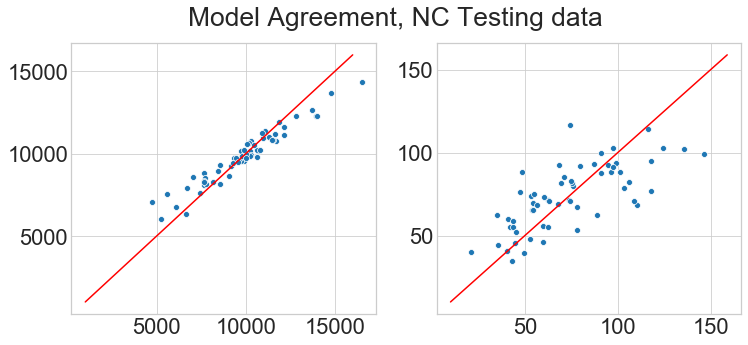

In [29]:
sns.set_style("whitegrid")
f, axes = plt.subplots(1, 2, figsize=(12,5))
f.suptitle("Model Agreement, NC Testing data")

sns.scatterplot(NC_df["biomass_60"].values, NC_preds, ax= axes[0])
sns.lineplot(np.arange(1000,16000,1), np.arange(1000,16000,1), color='red', ax=axes[0])

sns.scatterplot(NC_df["shoot_n_kg_ha_60"].values, NC_preds_n, ax= axes[1])
sns.lineplot(np.arange(10,160,1), np.arange(10,160,1), color='red', ax=axes[1])

plt.show()

Relative to the check models (simple multiple regression), the **`Random Forest`** model reduced biomass prediction error (RMSE) in the validation dataset by 70% whereas **`LASSO`** did so for shoot N predictions albeit less drastically (-28%). Error metrics and model performance are reported in the two cells below.

In [30]:
# Biomass -- How does the check model do with this data (LM)?
check_bm_preds=rmf.model_train_test(output= NC_df["biomass_60"].values,      
                                    x_sample= np.array(NC_df.loc[:,vars_30]),
                                    test_size= 0.40, #0.15
                     phase= "training",
                     model= LinearRegression())[["rmse","mae"]]
check_bm_preds

,rmse,mae
0,2442.349418,1951.894043


In [31]:
# Biomass -- Best ML model -- How does the optimized Random Forest do?
final_bm_preds= rf_opt_bm.fit(X= np.array(NC_df.loc[:,vars_30]),
                              y=  NC_df["biomass_60"].values).predict(np.array(NC_df.loc[:,vars_30]))
final_test_RMSE= mean_squared_error(y_true= NC_df["biomass_60"].values, 
                                    y_pred= final_bm_preds)
final_test_MAE= mean_absolute_error(y_true= NC_df["biomass_60"].values, 
                                     y_pred= final_bm_preds)

print({"RMSE, Final test (NC) ": np.sqrt(final_test_RMSE),
       "MAE Final test (NC) ": final_test_MAE})

{'RMSE, Final test (NC) ': 797.259921504461, 'MAE Final test (NC) ': 599.1659756662385}


In [32]:
# Shoot-N --  How does the check model do with this data (LM)?
rmf.model_train_test(
    output= NC_df["shoot_n_kg_ha_60"].values,
    x_sample= np.array(NC_df.loc[:, vars_30]),
    test_size=0.40,
    phase= "training",
    model= LinearRegression()
)

,bias,var,rmse,mae,r2
0,-0.245827,208.444101,24.528021,20.305127,0.439675


In [33]:
# Shoot-N -- Best ML model -- How does the optimized LASSO model do?
final_n_preds= ls_opt_n.fit(X= np.array(NC_df.loc[:,vars_30]),
                              y=  NC_df["shoot_n_kg_ha_60"].values).predict(np.array(NC_df.loc[:,vars_30]))
final_n_test_RMSE= mean_squared_error(y_true= NC_df["shoot_n_kg_ha_60"].values, 
                                    y_pred= final_n_preds)
final_n_test_MAE= mean_absolute_error(y_true= NC_df["shoot_n_kg_ha_60"].values, 
                                      y_pred= final_n_preds)

print({"RMSE, Final test (NC) ": np.sqrt(final_n_test_RMSE),
       "MAE Final test (NC) ": final_n_test_MAE})

{'RMSE, Final test (NC) ': 19.206513942532595, 'MAE Final test (NC) ': 15.132958655293889}


The figure below encapsulates the nutshell of the project, which was geared towards finding more accurate predictions of cover crop performance across a gradient of fertility environments. In spite of the importance of soil nitrogen for quick crop establishment and growth, cover crops may grow in soils where N availability is variable due to previous cash crop's uptake, soil losses, etc. The field trial assessed this hypothesis, testing rye plots at different N rate combinations (fall x spring). ML predictions (*blue line* in the figure below) compared fairly accurate relative to 95% bootstrap CI's of sampled biomass and shoot N content available at every N rate in the field experiment (*green lines*).

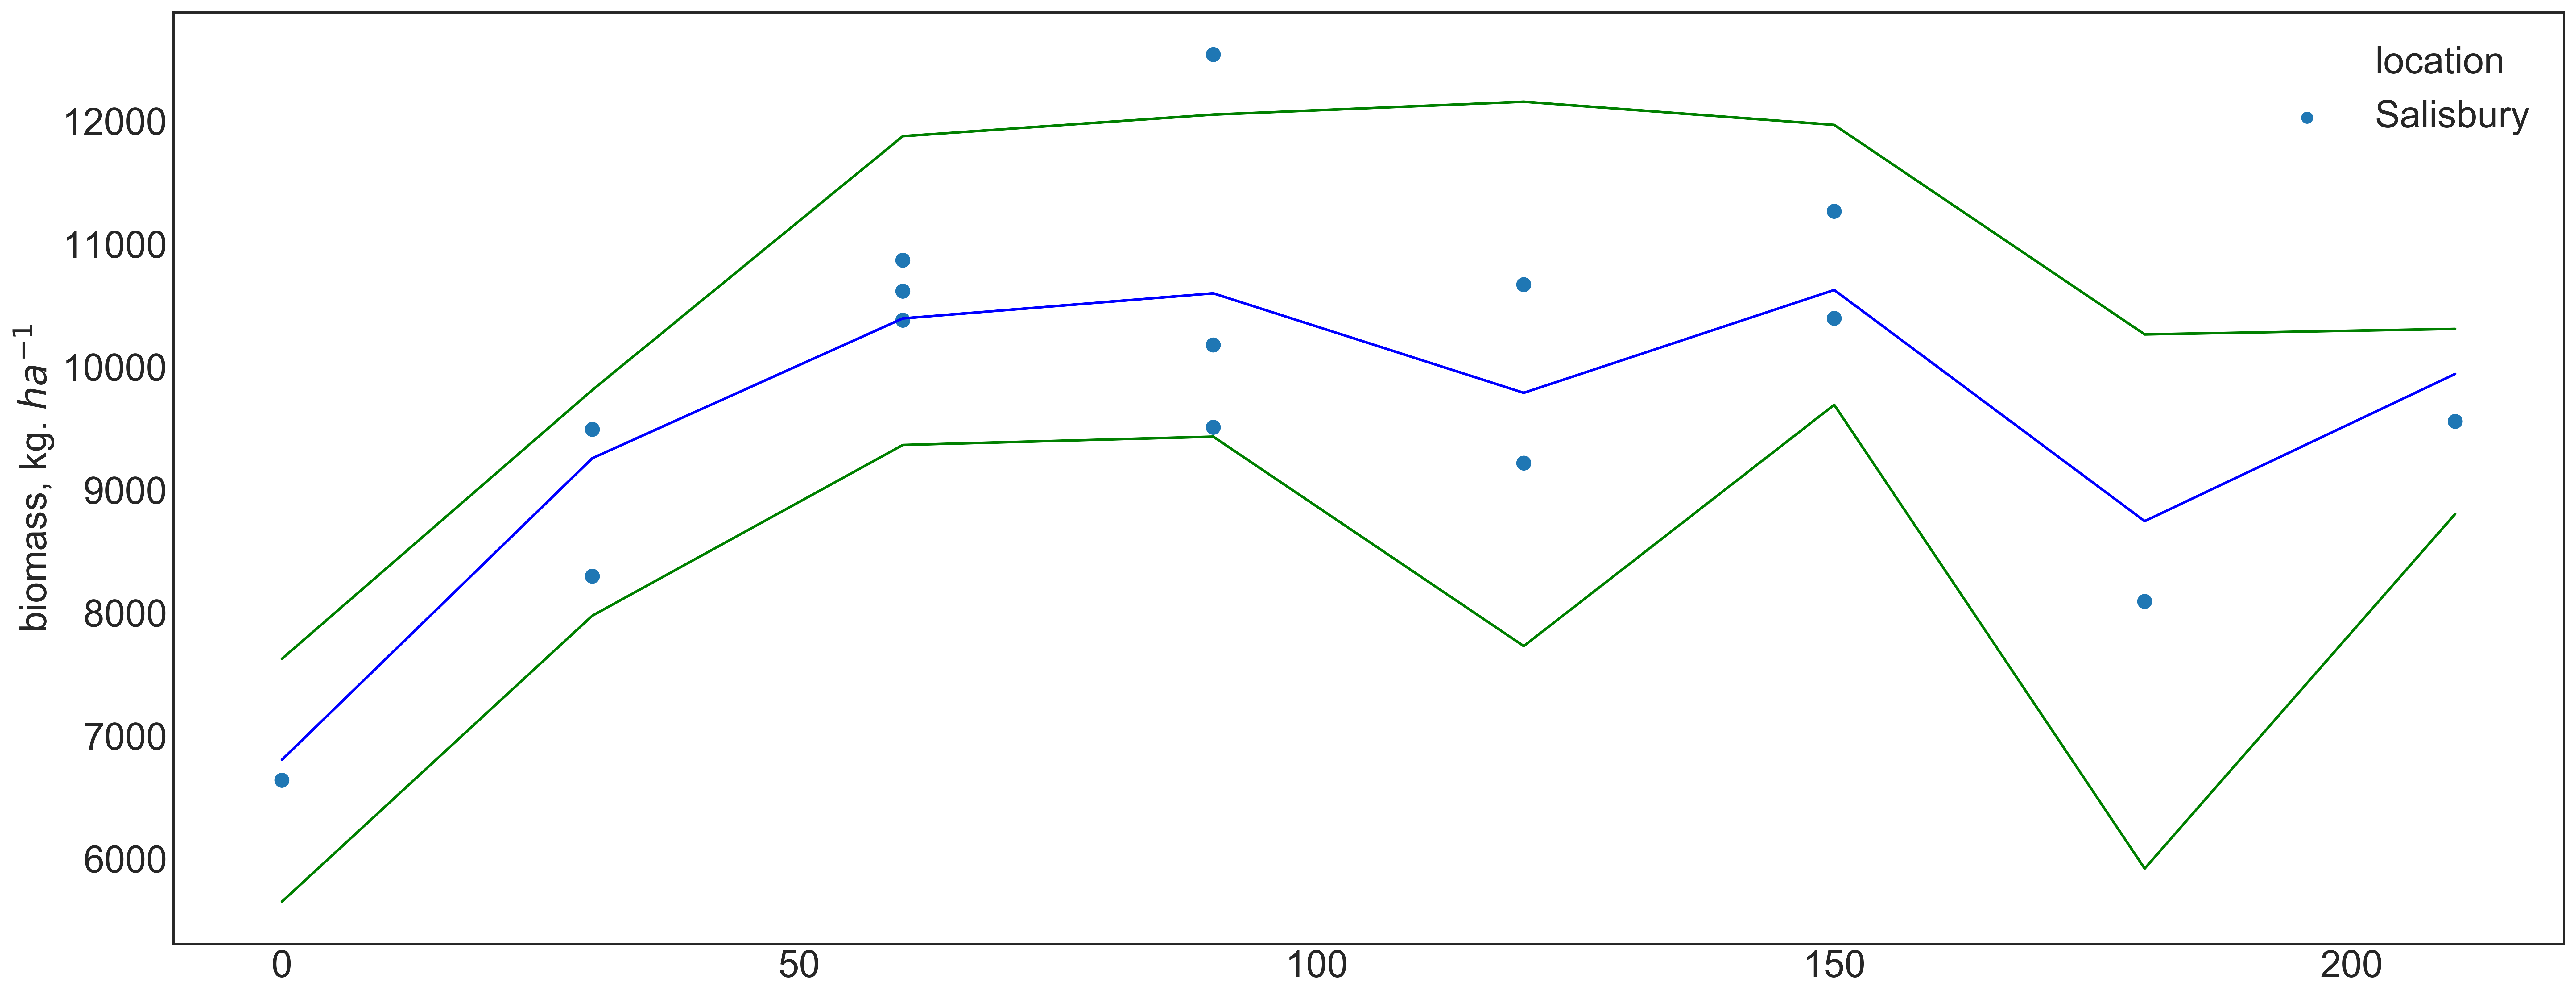

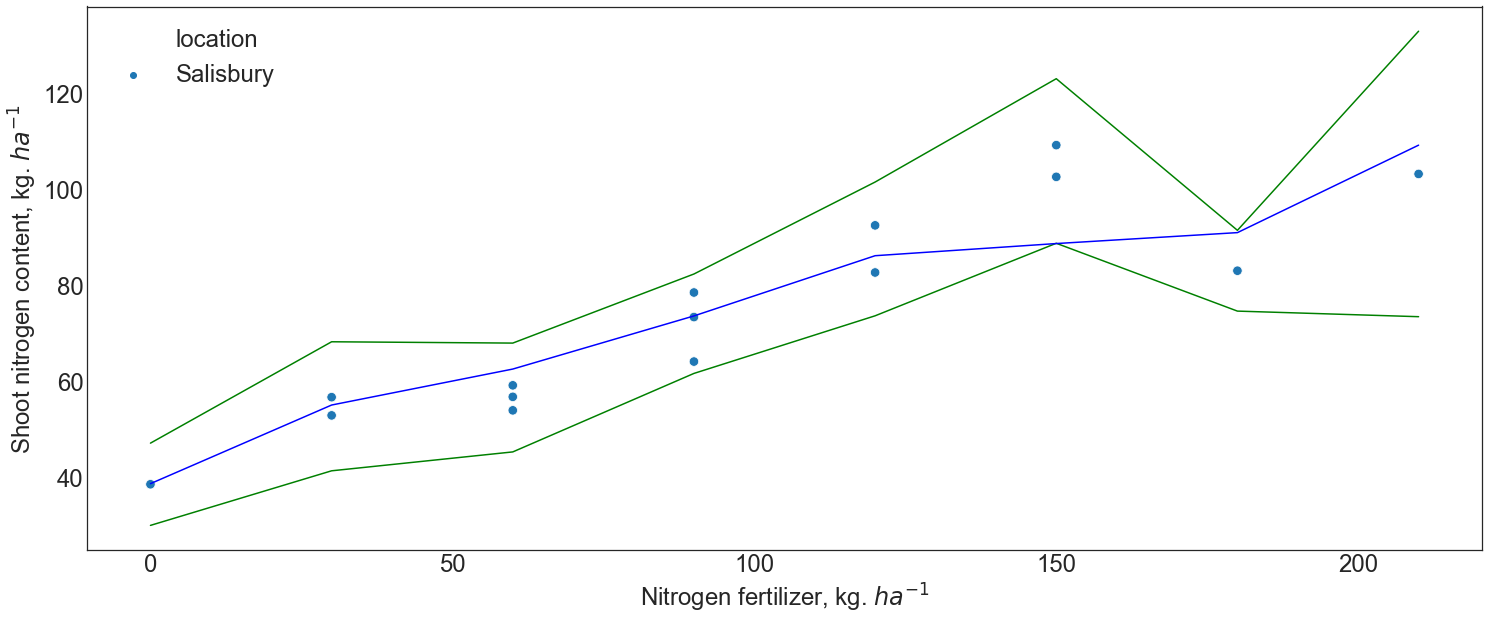

<Figure size 432x288 with 0 Axes>

In [34]:
# -----------------Model Application: ML Predictions for North Carolina (Unseen data) --------------------- ####
# ---------------------------- Nitrogen response over a continuum Rate gradient ---------------
#sns.set_style("whitegrid")
plt.style.use('seaborn-white')
plt.figure(1, figsize=(25,10), dpi=400)
#plt.figure(figsize=(width,height), dpi=400)
#plt.title("North Carolina, Testing data")
                  
sns.scatterplot('total_N_rate', 'obs_mean', hue='location',data=NC_b, s= 90)                           
sns.lineplot('total_N_rate', 'upper_obs_mean',data= NC_b, color='green', err_style=None) 
sns.lineplot('total_N_rate', 'lower_obs_mean',data= NC_b, color='green', err_style=None)
sns.lineplot('total_N_rate', 'pred_biomass',data= NC_b, color='blue', err_style=None) 
#sns.pointplot('n_rate_fall', 'mean_bst', hue="n_rate_spring",
#   data= NC_b, dodge=True, join=False)
plt.xlabel('')
plt.ylabel('biomass, kg. $ha^{-1}$')
plt.rcParams['font.size'] = 24
plt.show()

# ---------------------- shoot N
plt.figure(2, figsize=(25,10))
                  
sns.scatterplot('total_N_rate', 'obs_n', hue='location',data=NC_n, s= 90)                           
sns.lineplot('total_N_rate', 'upper_obs_n',data= NC_n, color='green', err_style=None) 
sns.lineplot('total_N_rate', 'lower_obs_n',data= NC_n, color='green', err_style=None)
sns.lineplot('total_N_rate', 'pred_n',data= NC_n, color='blue', err_style=None) 
#sns.pointplot('n_rate_fall', 'mean_bst', hue="n_rate_spring",
#   data= NC_b, dodge=True, join=False)
plt.xlabel(r"Nitrogen fertilizer, kg. $ha^{-1}$")
plt.ylabel(r"Shoot nitrogen content, kg. $ha^{-1}$")
plt.rcParams['font.size'] = 22
plt.show()

plt.savefig('foo.png')

This end-to-end project shows that Machine Learning algorithms were able to capture data signals from a small and quite correlated yet informative dataset, based solely on crop intrinsic features (i.e. sensed vegetation and field measured allometrics). There is promise to increase model testing capabilities by merging additional layers of information (geospatial weather and soil properties), "engineer" hidden features from first principles (mechanistic crop models), and extent the range of predictions beyond sole cover crop performance (e.g. cash crop impacts). In line with multiple applications of machine learning, and modeling in general, no single model can be said to be a "one size fits all" recipe.

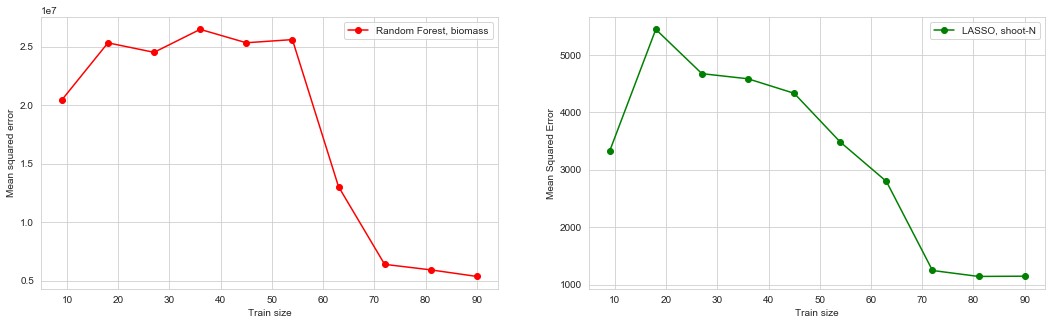

In [21]:
# ----------------------------------- OPTIONAL MATERIALS ----------------------------------------------
# Either for appendices or final inclusion depending on the extension the paper will turn in

# I am  including one of such figures for reference;
# One example of such figure is the training sample curve, using an simple "elbow" approach

# Suppl.1) best training size -- Learning curves
plt.figure(figsize=(18,5))

plt.subplot(1, 2, 1)
train_sizes_rf, train_scores_rf, test_scores_rf=\
learning_curve(rf_opt_bm, X_full[:100], y_bm[:100], train_sizes= np.linspace(0.1,1,10),
              scoring="neg_mean_squared_error",cv=10)
plt.plot(train_sizes_rf,-test_scores_rf.mean(1), 'o-', color='r', label='Random Forest, biomass')
plt.xlabel("Train size")
plt.ylabel("Mean squared error")
plt.legend(loc='best')

plt.subplot(1,2,2)
train_sizes_ls, train_scores_ls, test_scores_ls=\
learning_curve(ls_opt_n, X_full[:100], y_n[:100], train_sizes= np.linspace(0.1,1,10),
              scoring="neg_mean_squared_error", cv=10)
plt.plot(train_sizes_ls, -test_scores_ls.mean(1), 'o-', color='g', label='LASSO, shoot-N')
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.legend(loc='best')
plt.show()

# Variable selection and Features of importance

In [108]:
X_full.shape

X_selection= pd.DataFrame(X_full.copy()) #full[vars_25+vars_30]
names= ['tiller efficiency','biomass','ndvi','N content','N efficiency','C content','CN ratio']
names_20, names_30= [i + ' 20' for i in names], [i + ' 30' for i in names]
X_selection.columns= names_20 + names_30

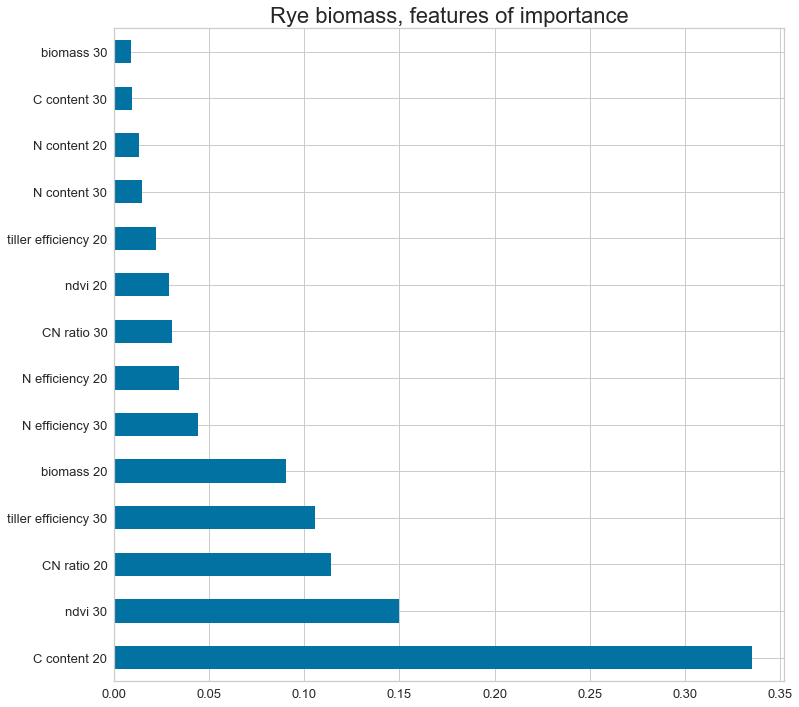

In [109]:
# Biomass selection (random forest)
selection_biomass_model= rf_opt_bm
selection_biomass_model.fit(X_selection, y_bm)


fig= plt.figure(figsize=(12,12))

ax= fig.add_subplot(111)
pd.Series(
    rf_opt_bm.feature_importances_,
    index= X_selection.columns
).nlargest(14).plot(kind='barh')
ax.set_title('Rye biomass, features of importance', fontsize= 22)
ax.grid(True)
plt.tick_params(labelsize=13)
plt.show()
fig.savefig('BiomassAttributes.png', dpi=400)

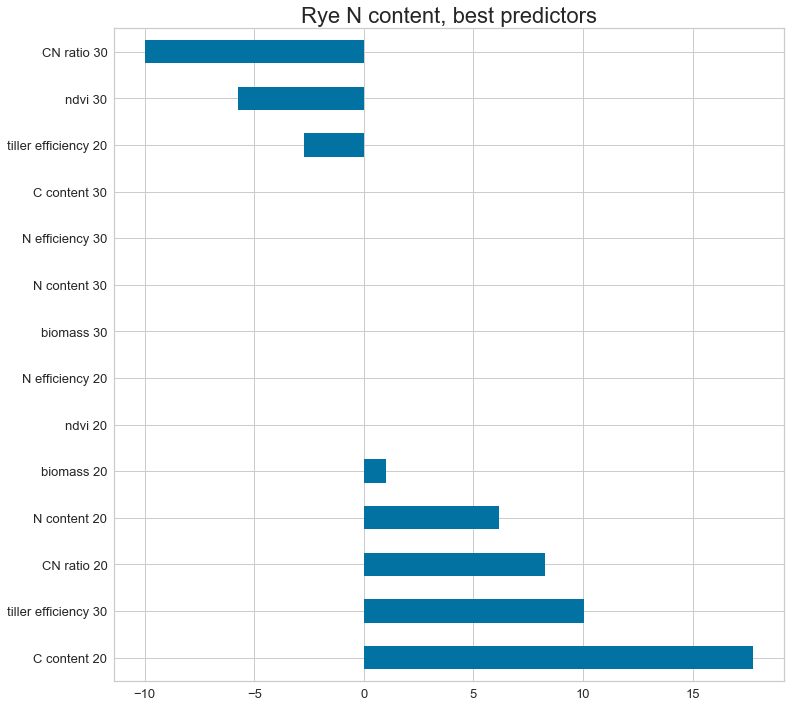

In [113]:
# N content selection (LASSO)
# selection_ncontent_model= ls_opt_n
# selection_ncontent_model.fit(X_selection, y_n)

fig= plt.figure(figsize=(12,12))

ax= fig.add_subplot(111)
pd.Series(
    ls_opt_n.coef_,
    index= X_selection.columns
).nlargest(14).plot(kind='barh')
ax.set_title('Rye N content, best predictors', fontsize= 22)
ax.grid(True)
plt.tick_params(labelsize=13)
plt.show()
fig.savefig('NcontentAttributes.png', dpi=400)

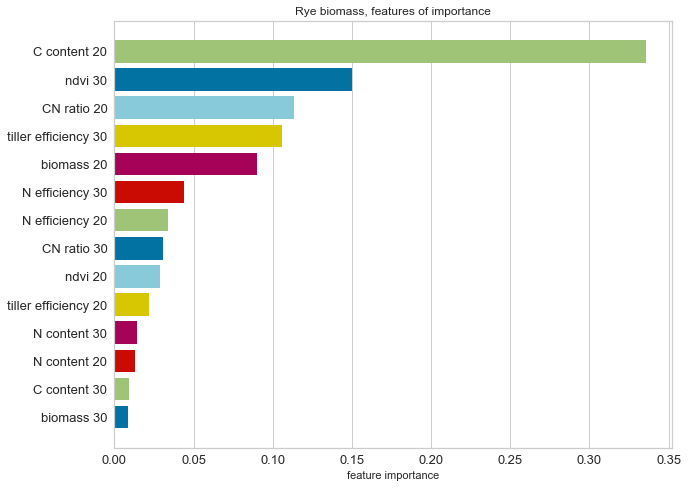

In [129]:
from yellowbrick.model_selection import FeatureImportances
viz_bm= FeatureImportances(rf_opt_bm, relative=False, title= 'Rye biomass, features of importance',size=(700, 500))
viz_bm.fit(X_selection, y_bm)
plt.tick_params(labelsize=13)
viz_bm.show(outpath="BiomassAttributesVizualization.png")
plt.show()

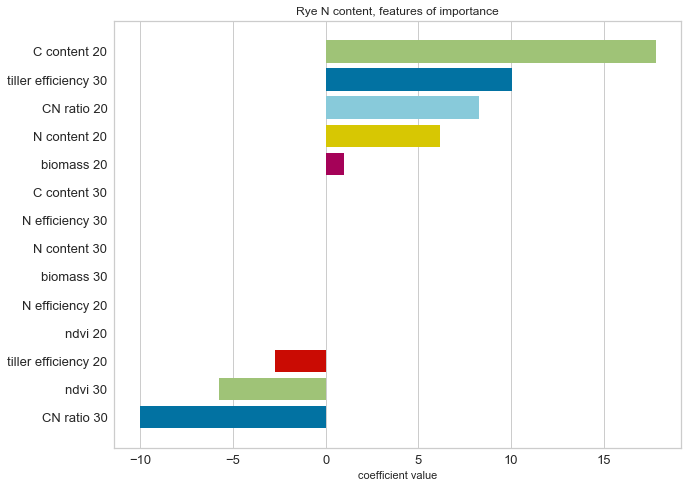

In [126]:
viz_n= FeatureImportances(ls_opt_n, relative=False, title= 'Rye N content, features of importance',size=(700, 500))
viz_n.fit(X_selection, y_n)
plt.tick_params(labelsize=13)
viz_n.show(outpath='NContentAttributesVizaualization.png')
plt.show()

In [74]:
X_selection=  pd.DataFrame(X_full.copy()) #full[vars_25+vars_30] #
X_selection.columns= names_20 + names_30
selection_lm= LinearRegression()
selection_lm.fit(X_selection, y_n)
pd.Series(selection_lm.coef_, index= X_selection.columns)

tiller efficiency 20   -10.683947
biomass 20             -16.197487
ndvi 20                  0.358977
N content 20            18.236816
N efficiency 20          4.257869
C content 20            28.551576
CN ratio 20             14.179651
tiller efficiency 30    11.860242
biomass 30             -25.255808
ndvi 30                -11.372053
N content 30            17.608410
N efficiency 30         -5.272153
C content 30            11.442022
CN ratio 30            -10.820248
dtype: float64

In [38]:
finish_time= time.clock() - begin_time
print("Total simulation time was : {}".format(round(finish_time,3)))

Total simulation time was : 5778.193
